<h1>Analysis of Tumor Exome Mutations</h1>

<!--[cancer_cells](https://swami.wustl.edu/wp-content/uploads/2015/07/cancers-cells-1038x576.jpg)-->
<img src="https://swami.wustl.edu/wp-content/uploads/2015/07/cancers-cells-1038x576.jpg" alt="cancer cells" width="600px">

<h2>Author: Yogindra Raghav</h2>
<h2>Email: yraghav97@gmail.com</h2>

In [11]:
import pandas
import itertools 
import collections
import matplotlib.pyplot as plt
import fisher 

<h3>Load All DataFrames into Dict</h3>

In [2]:
# dict for all MAF data 
all_mafs = {}

# for all 50 MAF files 
for i in range(0,50): 
    # load all MAF data into dict using patient number as key 
    all_mafs["Patient-"+str(i)] = pandas.read_csv("mafs/Patient-"+str(i)+".somatic.snvs.maf", sep="\t")
    

<h3>Subset for: NOT Variant Classification "Silent"</h3>

In [3]:
# dict for dataframes subsetted for non-silent variants 
not_silent = {} 

# for all MAFs
for maf in all_mafs: 
    # subset for variants that are not "silent" variants 
    not_silent[maf] = all_mafs[maf].loc[all_mafs[maf]["Variant_Classification"]!="Silent"]

not_silent["Patient-0"].head()

,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count
0,AMOT,X,112035152,112035152,Missense_Mutation,SNP,G,G,C,Patient-0-Tumor,Patient-0-Normal,p.Q612E,8,31
1,SEMA6D,15,48062786,48062786,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.A676T,4,87
2,PRR12,19,50100969,50100969,Missense_Mutation,SNP,C,C,G,Patient-0-Tumor,Patient-0-Normal,p.S1126C,5,25
7,ZNF253,19,20002885,20002885,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.V277I,6,66
8,MEF2C,5,88025061,88025061,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.S313L,6,42


<h3>Create Histogram of 10 Most Common Mutations</h3>

**Populate Dict to Build Histogram**

In [4]:
# dict for plotting histogram 
histogram_plot_dict = {} 

# for each dataframe 
for dataframe in not_silent: 
    # get list of hugo symbols from dataframe
    hugo_genes = not_silent[dataframe]["Hugo_Symbol"].tolist()
    
    # update histogram dict for future plotting 
    for gene in hugo_genes:
        if gene in histogram_plot_dict: 
            histogram_plot_dict[gene] +=1
        else: 
            histogram_plot_dict[gene] = 1

**Pull 10 Highest Counts' Genes**

In [5]:
# sort dict by values (highest to lowest) 
histogram_plot_dict={k: v for k, v in sorted(histogram_plot_dict.items(), key=lambda item: item[1], reverse=True)}

# pull first 10 times and coerce to dict for future plotting 
histogram_plot_dict = dict(itertools.islice(histogram_plot_dict.items(), 0,10))

# print dict clean 
for gene in histogram_plot_dict: 
    print(gene+"\t"+str(histogram_plot_dict[gene]))

TTN	41
TP53	30
ERBB4	27
MUC16	22
SPEN	22
KMT2C	20
KMT2D	17
ERBB3	16
FRG1B	14
ZNF91	13



**Create Figure**

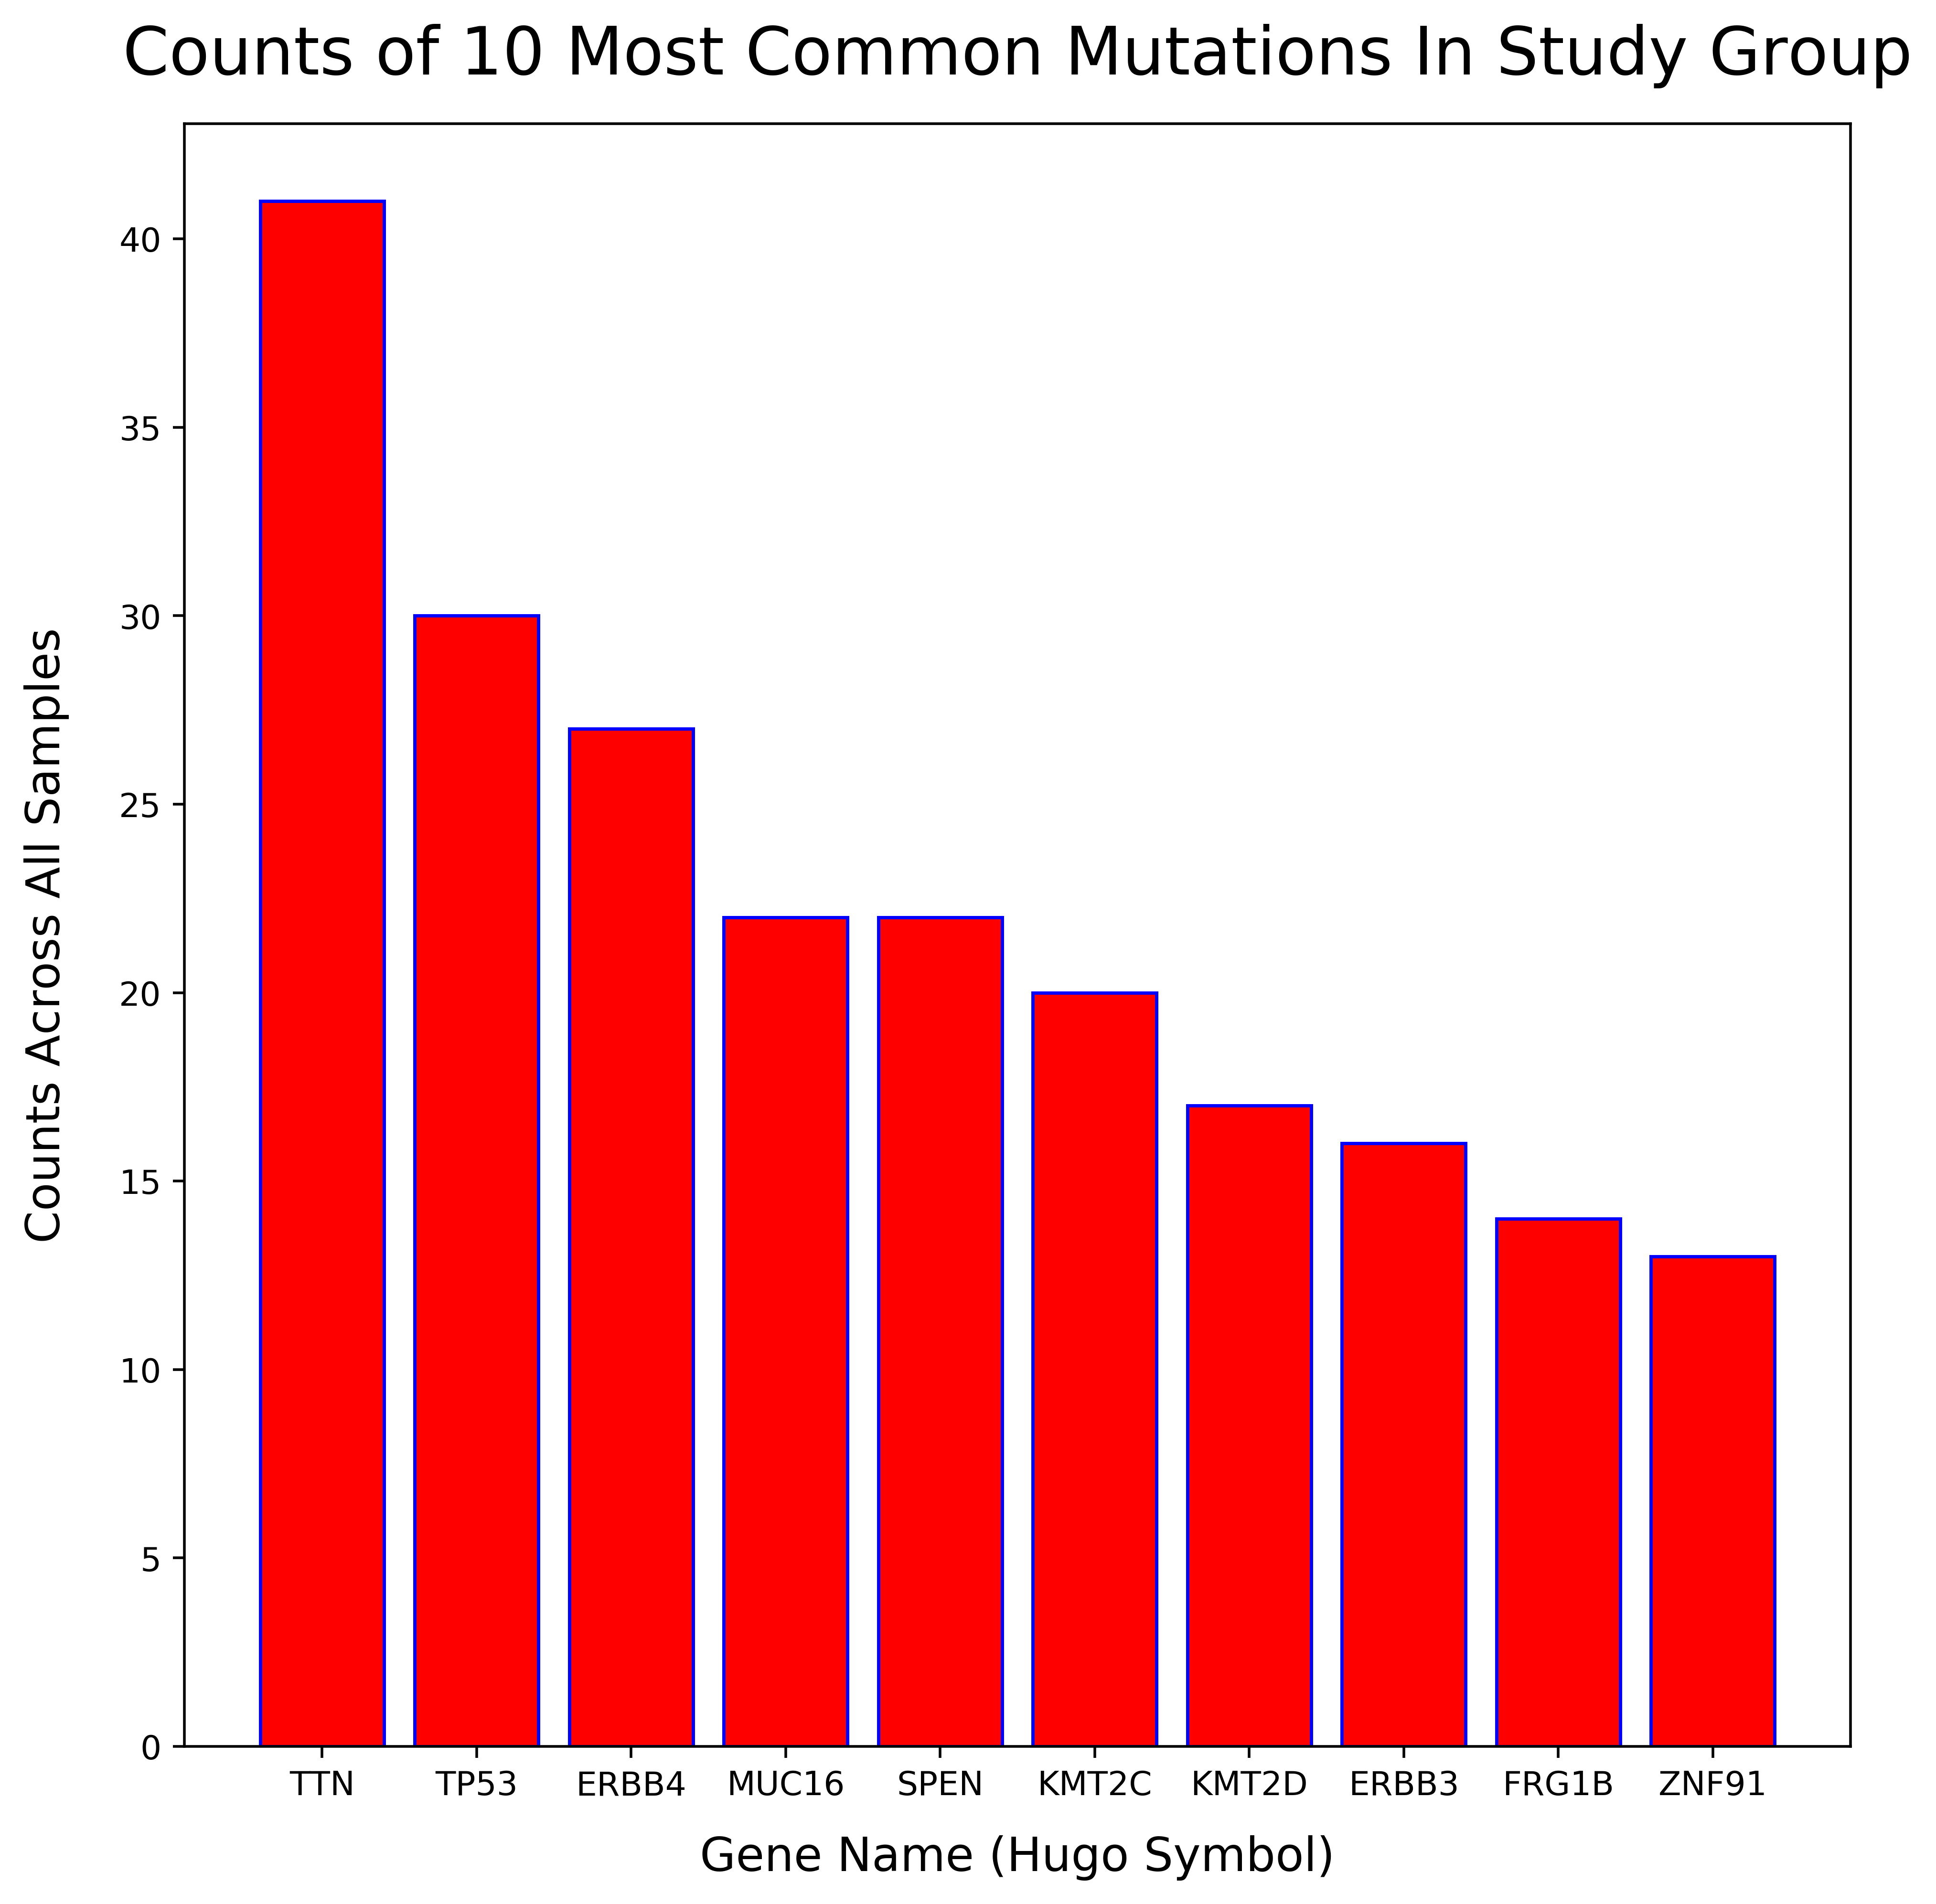

In [6]:
# adjust figure size and quality 
plt.figure(figsize=(9,9), dpi = 500)

# make bar plot 
plt.bar(histogram_plot_dict.keys(), histogram_plot_dict.values(), color="red", edgecolor="blue")

# update y label 
plt.ylabel("Counts Across All Samples", labelpad=15, size=14)
# update x label 
plt.xlabel("Gene Name (Hugo Symbol)", labelpad=10, size=14)
# update title 
plt.title("Counts of 10 Most Common Mutations In Study Group", size=20, pad=15)

#show plot
plt.show()

<h3>Are Any Mutated Genes Significantly Enriched in Patients who Responded or Not?</h3>

**Load Patient Metadata** 

In [7]:
# read tsv and use patient ID as index 
patient_metadata = pandas.read_csv("./sample-information.tsv", sep="\t", index_col=0)
patient_metadata.head()

,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Response,Silent_mutations_per_Mb,Nonsynonymous_mutations_per_Mb,Mutations_per_Mb
Patient_ID,,,,,,
Patient-0,Patient-0-Tumor,Patient-0-Normal,Non-Responder,2.87,6.77,9.64
Patient-1,Patient-1-Tumor,Patient-1-Normal,Responder,1.92,6.14,8.06
Patient-2,Patient-2-Tumor,Patient-2-Normal,Responder,1.32,2.84,4.16
Patient-3,Patient-3-Tumor,Patient-3-Normal,Non-Responder,1.78,5.00,6.78
Patient-4,Patient-4-Tumor,Patient-4-Normal,Responder,4.93,10.50,15.43


**Find All Unique Genes (Hugo Symbols)**

In [8]:
# list of all unique genes 
hugo_symbols = []

# for each dataframe 
for dataframe in not_silent: 
    # get list of hugo symbols from dataframe
    hugo_symbols.extend(not_silent[dataframe]["Hugo_Symbol"].tolist())

# de-dupe the list
hugo_symbols = list(set(hugo_symbols))
len(hugo_symbols)

6927

**Calculate Contingency Tables for Each Gene**

In [13]:
# create dict indexed by gene containing each contingency table
contingency_tables = {}

# for each gene (hugo symbol) 
for gene in hugo_symbols: 
    """
    CONTINGENCY TABLE VARIABLES
    """
    # had mutation and responded 
    mutation_responded = 0 
    # no mutation and responded 
    no_mutation_responded = 0
    # mutation and didn't respond  
    mutation_not_responded =0 
    # no mutation and not responded 
    no_mutation_not_responded =0 
    """
    END
    """
    
    # for each dataframe (each named after patient ID) 
    for dataframe in not_silent:
        # get responder status (i.e. responder to drug or did not respond) 
        response_status = patient_metadata.at[dataframe, "Response"]
        # find out if patient has mutation or not 
        has_mutation = not_silent[dataframe]["Hugo_Symbol"].str.contains(gene).any()
        
        # mutation and responded 
        if has_mutation and response_status == "Responder": 
            mutation_responded+=1 
        # no mutation and responded 
        elif not has_mutation and response_status == "Responder": 
            no_mutation_responded+=1
        # mutation and didn't respond 
        elif has_mutation and response_status=="Non-Responder": 
            mutation_not_responded+=1 
        # no mutation and didn't respond 
        elif not has_mutation and response_status=="Non-Responder": 
            no_mutation_not_responded+=1
    
    # add contingency table to dict 
    contingency_tables[gene] = [mutation_responded, no_mutation_responded,mutation_not_responded, no_mutation_not_responded]


**Calculate P-Values Using Fisher's Exact Test**

In [40]:
# for each gene 
for gene in contingency_tables: 
    # get list of contingency table values 
    contingency_table_values = contingency_tables[gene]
    
    # calculate p values using fisher's exact test 
    p = fisher.pvalue(contingency_table_values[0],contingency_table_values[1],contingency_table_values[2],contingency_table_values[3])
    
    # if two-tail test p value is less than 0.05 (i.e. significant)
    if p.two_tail <=0.05: 
        # identify which genes and associated information are "significant" 
        print(gene+"\t"+ str(contingency_tables[gene])+"\t"+str(p))


HECTD1	[6, 19, 0, 25]	PValues(left_tail=1, right_tail=0.01114, two_tail=0.02229)
AHNAK	[9, 16, 2, 23]	PValues(left_tail=0.9977, right_tail=0.01871, two_tail=0.03743)
MET	[11, 14, 2, 23]	PValues(left_tail=0.9996, right_tail=0.004149, two_tail=0.008299)
ERCC2	[9, 16, 0, 25]	PValues(left_tail=1, right_tail=0.0008154, two_tail=0.001631)
CDC7	[8, 17, 0, 25]	PValues(left_tail=1, right_tail=0.002015, two_tail=0.004029)
KMT2C	[7, 18, 1, 24]	PValues(left_tail=0.998, right_tail=0.0244, two_tail=0.0488)
F10	[16, 9, 7, 18]	PValues(left_tail=0.998, right_tail=0.01112, two_tail=0.02224)
AKAP1	[7, 18, 0, 25]	PValues(left_tail=1, right_tail=0.004813, two_tail=0.009625)
AKAP9	[6, 19, 0, 25]	PValues(left_tail=1, right_tail=0.01114, two_tail=0.02229)
MROH2B	[6, 19, 0, 25]	PValues(left_tail=1, right_tail=0.01114, two_tail=0.02229)
C5	[22, 3, 14, 11]	PValues(left_tail=0.9982, right_tail=0.01274, two_tail=0.02548)
MICA	[9, 16, 1, 24]	PValues(left_tail=0.9997, right_tail=0.00529, two_tail=0.01058)
SI	[17, 8,